#**CLASSIFICATION TASK 2 - Irony vs Sarcasm**

In this notebook, we experiment with different models to **classify tweets with figurative language into sarcasm and irony** (the one we referred to as Classification Task 2 in the report). By employing various techniques, we aim to analyze the effectiveness of each model in capturing the nuances of language expression in tweet. <br>
Most of the models were trained on both the **post-feature selection and pre-feature selection datasets** to assess the effectiveness of our selection strategy. For some models, we also opted to investigate further by comparing the **impact of different vectorization techniques** (Word2Vec vs CountVectorizer). In case of POST Feature Selection, along with other models, we altro tried **RoBERTa base**, that is a model trained on ~58M tweets and finetuned for irony detection.  

# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
import torch.nn as nn
from transformers import TFAutoModelForSequenceClassification
from sklearn.naive_bayes import MultinomialNB
from scipy.special import softmax
import csv
import urllib.request
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack, csr_matrix
from gensim.models import Word2Vec



#from google.colab import drive
#drive.mount('/content/drive')

#!pip install scikit-learn
#!pip install transformers
#!pip install torch
#!pip install accelerate


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# POST Feature Selection

## BERT

In [ ]:
train_csv = "dataset_second_task/ST_traindata_featureselection.csv"
test_csv = "dataset_second_task/ST_testdata_featureselection.csv"

df_train = pd.read_csv(train_csv, encoding='utf-8') #names=['id','text'],
df_test = pd.read_csv(test_csv, encoding='utf-8')

y_train = df_train['label']
y_test = df_test['label']

df_train.head(3)

,label,introspection,Calendric_unit,temper,sensitivity,index,Text,Experiencer_obj,syno_lower_mean,syn_mean,...,thoroughly_enjoy,heat,irony,love,makes,says,song,today,desire_succeed,tweet
0,0,-0.001545,1,-0.156364,0.060455,0,0,0,0.439955,0.272727,...,0,0,0,0,0,0,0,0,0,im fucking excited tonights bluejays game cant...
1,0,0.112500,0,0.000000,0.000000,1,0,0,0.549383,0.450000,...,1,0,0,0,0,0,0,0,0,funny take picture draw penis someones mouth. ...
2,0,0.059182,0,-0.076364,0.124091,2,0,0,0.262626,0.209091,...,0,0,0,0,0,0,0,0,1,love mom acting like nothing happened. kill so...


In [ ]:
# verifica disponibilità GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Stai usando: {device}")

# tokenizer BERT e modello pre-addestrato
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)


class CustomDataset(Dataset):
    def __init__(self, text, labels, tokenizer, max_length):
        self.encodings = tokenizer(list(text), truncation=True, padding=True, max_length=max_length, return_tensors='pt')
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

max_length = 128
train_dataset = CustomDataset(df_train['tweet'], y_train, tokenizer, max_length)
val_dataset = CustomDataset(df_test['tweet'], y_test, tokenizer, max_length)

# carica dati in DataLoader con opzione pin_memory
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

num_epochs = 25
train_losses = []
val_losses = []

# addestramento del modello
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(average_train_loss)

    # valutazione del modello sul set di validazione
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    average_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(average_val_loss)

    print(f'Epoch {epoch+1}, Training Loss: {average_train_loss}, Validation Loss: {average_val_loss}')

Stai usando: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Training Loss: 0.7455584183335304, Validation Loss: 0.6675359383225441
Epoch 2, Training Loss: 0.6621211059391499, Validation Loss: 0.6429966762661934
Epoch 3, Training Loss: 0.6220145598053932, Validation Loss: 0.5855323299765587
Epoch 4, Training Loss: 0.5508580822497606, Validation Loss: 0.5433829464018345
Epoch 5, Training Loss: 0.4805456195026636, Validation Loss: 0.5335024558007717
Epoch 6, Training Loss: 0.42523204162716866, Validation Loss: 0.4916800819337368
Epoch 7, Training Loss: 0.34911603666841984, Validation Loss: 0.5035356394946575
Epoch 8, Training Loss: 0.29081414081156254, Validation Loss: 0.5084924027323723
Epoch 9, Training Loss: 0.23251256439834833, Validation Loss: 0.5292689502239227
Epoch 10, Training Loss: 0.1827473621815443, Validation Loss: 0.5792476199567318
Epoch 11, Training Loss: 0.14064996084198356, Validation Loss: 0.6049117036163807
Epoch 12, Training Loss: 0.11150598153471947, Validation Loss: 0.6388917118310928
Epoch 13, Training Loss: 0.0883

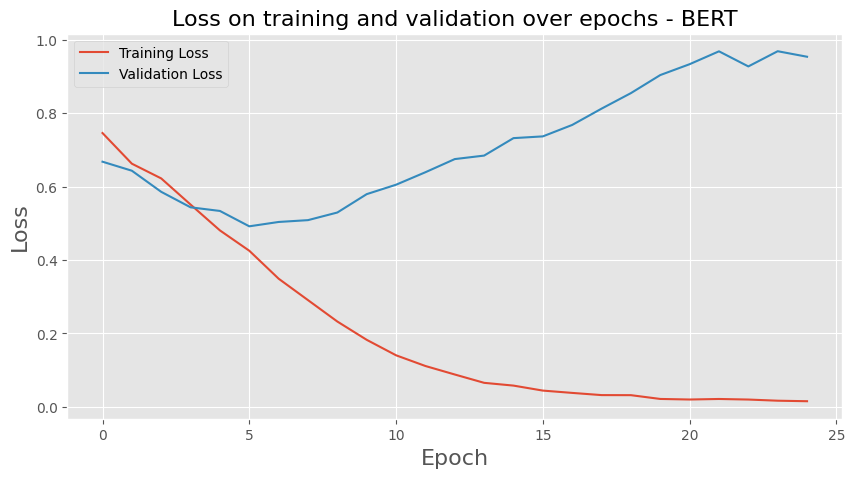

In [ ]:
# plot della loss
plt.figure(figsize=(10, 5))
plt.style.use('ggplot')
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.title('Loss on training and validation over epochs - BERT', fontsize = 16)
plt.legend()
plt.savefig('grafico_loss_bert_secondtask.svg')
plt.savefig('grafico_loss_bert_secondtask.png')
plt.show()

In [ ]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


In [ ]:
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.2f}')
print('Classification report:', classification_report(y_test, predictions))

Accuracy: 0.79
Classification report:               precision    recall  f1-score   support

           0       0.83      0.83      0.83       604
           1       0.73      0.74      0.74       384

    accuracy                           0.79       988
   macro avg       0.78      0.78      0.78       988
weighted avg       0.79      0.79      0.79       988



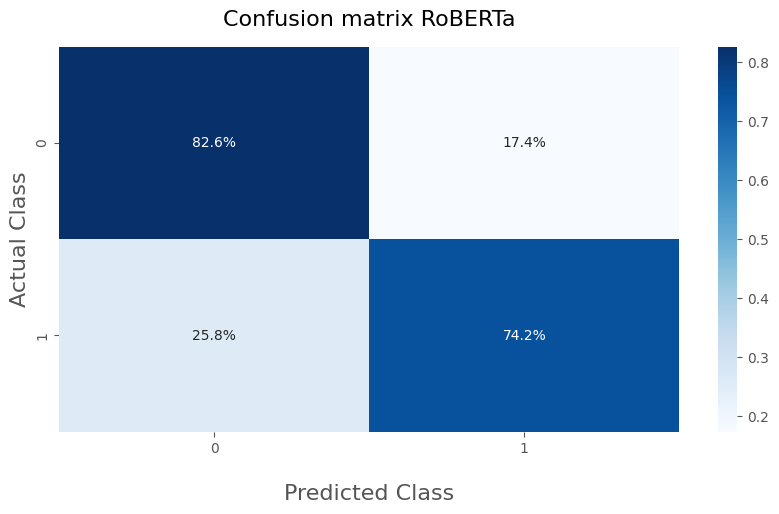

In [ ]:
cm = confusion_matrix(true_labels, predictions, normalize='true')
plt.figure(figsize=(10,5))
plt.style.use('ggplot')
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.1%') #cmap="PiYG
plt.xlabel("\nPredicted Class", fontsize = 16)
plt.ylabel("Actual Class", fontsize = 16)
plt.title('Confusion matrix RoBERTa', fontsize = 16, pad = 15)
plt.savefig('confusion_bert_secondtask.png')
plt.savefig('confusion_bert_secondtask.svg')
plt.show()


##RoBERTa

In [ ]:
train_csv = "dataset_second_task/ST_traindata_featureselection.csv"
test_csv = "dataset_second_task/ST_testdata_featureselection.csv"

df_train = pd.read_csv(train_csv, encoding='utf-8')
df_test = pd.read_csv(test_csv, encoding='utf-8') #names=['id','text'],

y_train = df_train['label']
y_test = df_test['label']


In [ ]:
# verifica disponibilità della GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Stai usando: {device}")

tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-irony')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-irony', num_labels=2)

model.to(device)
class CustomDataset(Dataset):
    def __init__(self, text, labels, tokenizer, max_length):
        self.encodings = tokenizer(list(text), truncation=True, padding=True, max_length=max_length, return_tensors='pt')
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


max_length = 208
train_dataset = CustomDataset(df_train['tweet'], y_train, tokenizer, max_length)
val_dataset = CustomDataset(df_test['tweet'], y_test, tokenizer, max_length)

batch_size = 300
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
num_epochs = 25

train_losses = []
val_losses = []

# training
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(average_train_loss)


    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    average_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(average_val_loss)

    print(f'Epoch {epoch+1}, Training Loss: {average_train_loss}, Validation Loss: {average_val_loss}')


Stai usando: cuda
Epoch 1, Training Loss: 0.8742027453013829, Validation Loss: 0.6917680501937866
Epoch 2, Training Loss: 0.6578842912401471, Validation Loss: 0.6277779340744019
Epoch 3, Training Loss: 0.6000382900238037, Validation Loss: 0.5835530459880829
Epoch 4, Training Loss: 0.5665604557309832, Validation Loss: 0.559464618563652
Epoch 5, Training Loss: 0.5278156527451107, Validation Loss: 0.5481062009930611
Epoch 6, Training Loss: 0.502484849521092, Validation Loss: 0.5448042005300522
Epoch 7, Training Loss: 0.46134268386023386, Validation Loss: 0.5310696288943291
Epoch 8, Training Loss: 0.41955264125551495, Validation Loss: 0.5179896429181099
Epoch 9, Training Loss: 0.38205147215298246, Validation Loss: 0.5214246138930321
Epoch 10, Training Loss: 0.3505465771470751, Validation Loss: 0.5255664885044098
Epoch 11, Training Loss: 0.3069754455770765, Validation Loss: 0.5536435320973396
Epoch 12, Training Loss: 0.268368376152856, Validation Loss: 0.5621457323431969
Epoch 13, Training 

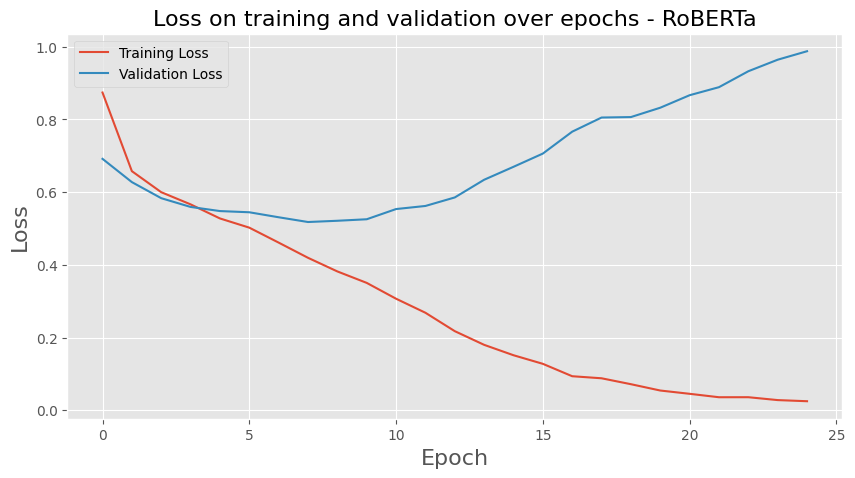

In [ ]:
# plot della loss
plt.figure(figsize=(10, 5))
plt.style.use('ggplot')
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.title('Loss on training and validation over epochs - RoBERTa', fontsize = 16)
plt.legend()
plt.savefig('grafico_loss_roberta.svg')
plt.savefig('grafico_loss_roberta.png')
plt.show()

In [ ]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [ ]:
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.78


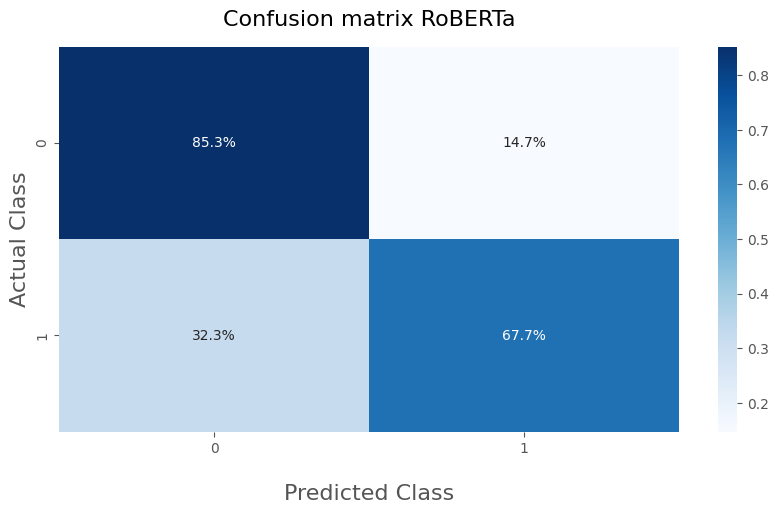

In [ ]:
cm = confusion_matrix(true_labels, predictions, normalize='true')
plt.figure(figsize=(10,5))
plt.style.use('ggplot')
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.1%') #cmap="PiYG
plt.xlabel("\nPredicted Class", fontsize = 16)
plt.ylabel("Actual Class", fontsize = 16)
plt.title('Confusion matrix RoBERTa', fontsize = 16, pad = 15)
plt.savefig('confusion_roberta.png')
plt.savefig('confusion_roberta.svg')
plt.show()


In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       604
           1       0.74      0.69      0.71       384

    accuracy                           0.79       988
   macro avg       0.78      0.77      0.77       988
weighted avg       0.78      0.79      0.78       988



## Logistic regression

### LR with CountVect

In [ ]:
train_file_csv = "dataset_second_task/ST_traindata_featureselection.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_second_task/ST_testdata_featureselection.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['tweet']
numerical_features_train = df_train.drop(['tweet', 'label'], axis=1).values

text_features_test = df_test['tweet']
numerical_features_test = df_test.drop(['tweet', 'label'], axis=1).values

vectorizer = CountVectorizer()
X_text_train_vec = vectorizer.fit_transform(text_features_train)
X_text_test_vec = vectorizer.transform(text_features_test)

X_train = hstack([X_text_train_vec, numerical_features_train])
X_test = hstack([X_text_test_vec, numerical_features_test])

# training
model = LogisticRegression()
model.fit(X_train, df_train["label"])

predictions = model.predict(X_test)

# evaluation
accuracy = accuracy_score(df_test["label"], predictions)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(df_test["label"], predictions))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.73

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       604
           1       0.66      0.62      0.64       384

    accuracy                           0.73       988
   macro avg       0.72      0.71      0.71       988
weighted avg       0.73      0.73      0.73       988



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### LR with Word Embeddings

In [ ]:
train_file_csv = "dataset_second_task/ST_traindata_featureselection.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_second_task/ST_testdata_featureselection.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['tweet']
numerical_features_train = csr_matrix(df_train.drop(['tweet', 'label'], axis=1).values)

X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["label"]

tokenized_text = [text.split() for text in X_text_train]
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

X_text_train_vec = [average_word_vectors(tokens, word2vec_model, word2vec_model.wv.index_to_key, 100) for tokens in tokenized_text]
X_text_train_vec = csr_matrix(X_text_train_vec)

text_features_test = df_test['tweet']
numerical_features_test = csr_matrix(df_test.drop(['tweet', 'label'], axis=1).values)

tokenized_test_text = [text.split() for text in text_features_test]
X_text_test_vec = [average_word_vectors(tokens, word2vec_model, word2vec_model.wv.index_to_key, 100) for tokens in tokenized_test_text]
X_text_test_vec = csr_matrix(X_text_test_vec)

X_train = hstack([X_text_train_vec, X_num_train])
X_test = hstack([X_text_test_vec, numerical_features_test])

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(df_test["label"], predictions)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(df_test["label"], predictions))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.66

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.80      0.74       604
           1       0.58      0.45      0.51       384

    accuracy                           0.66       988
   macro avg       0.64      0.62      0.63       988
weighted avg       0.65      0.66      0.65       988



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Naive Bayes

### NB with CountVect

In [ ]:
train_file_csv = "dataset_second_task/ST_traindata_featureselection.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_second_task/ST_testdata_featureselection.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['tweet']
numerical_features_train = df_train.drop(['tweet', 'label'], axis=1).values
numerical_features_train = np.abs(numerical_features_train)

text_features_test = df_test['tweet']
numerical_features_test = df_test.drop(['tweet', 'label'], axis=1).values
numerical_features_test = np.abs(numerical_features_test)

vectorizer = CountVectorizer()
X_text_train_vec = vectorizer.fit_transform(text_features_train)
X_text_test_vec = vectorizer.transform(text_features_test)

X_train = hstack([X_text_train_vec, numerical_features_train])
X_test = hstack([X_text_test_vec, numerical_features_test])

model = MultinomialNB()
model.fit(X_train, df_train["label"])

predictions = model.predict(X_test)

accuracy = accuracy_score(df_test["label"], predictions)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(df_test["label"], predictions))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.74

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       604
           1       0.73      0.54      0.62       384

    accuracy                           0.74       988
   macro avg       0.74      0.71      0.71       988
weighted avg       0.74      0.74      0.73       988



## Random Forest

###RF with Word Embeddings

In [ ]:
from sklearn.ensemble import RandomForestClassifier

train_file_csv = "dataset_second_task/ST_traindata_featureselection.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_second_task/ST_testdata_featureselection.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['tweet']
numerical_features_train = df_train.drop(['tweet', 'label'], axis=1).values

X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["label"]

sentences = [text.split() for text in X_text_train]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

X_text_train_vec = np.array([average_word_vectors(text.split(), word2vec_model, word2vec_model.wv.index_to_key, 100) for text in X_text_train])
X_text_test_vec = np.array([average_word_vectors(text.split(), word2vec_model, word2vec_model.wv.index_to_key, 100) for text in df_test['tweet']])

numerical_features_test = df_test.drop(['tweet', 'label'], axis=1).values

X_train = np.hstack([X_text_train_vec, X_num_train])
X_test = np.hstack([X_text_test_vec, numerical_features_test])

model = RandomForestClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(df_test["label"], predictions)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(df_test["label"], predictions))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.66

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.92      0.77       604
           1       0.68      0.26      0.37       384

    accuracy                           0.66       988
   macro avg       0.67      0.59      0.57       988
weighted avg       0.67      0.66      0.62       988



### RF with CountVect

In [ ]:
train_file_csv = "dataset_second_task/ST_traindata_featureselection.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_second_task/ST_testdata_featureselection.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['tweet']
numerical_features_train = df_train.drop(['tweet', 'label'], axis=1).values

X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["label"]

vectorizer = CountVectorizer()
X_text_train_vec = vectorizer.fit_transform(X_text_train)
X_text_test_vec = vectorizer.transform(df_test['tweet'])

numerical_features_test = df_test.drop(['tweet', 'label'], axis=1).values

X_train = np.hstack([X_text_train_vec.toarray(), X_num_train])
X_test = np.hstack([X_text_test_vec.toarray(), numerical_features_test])

model = RandomForestClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(df_test["label"], predictions)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(df_test["label"], predictions))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.72

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       604
           1       0.69      0.51      0.59       384

    accuracy                           0.72       988
   macro avg       0.71      0.68      0.69       988
weighted avg       0.72      0.72      0.71       988



# PRE Feature Selection - del tutto analogo al precedente

## Logistic regression

### LR con CountVect

In [ ]:
train_file_csv = "dataset_second_task/ST_train_text_frames_sentic_wordvect_syno.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_second_task/ST_test_text_frames_sentic_wordvect_syno.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['tweet']
numerical_features_train = df_train.drop(['tweet', 'label', 'id'], axis=1).values

X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["label"]

vectorizer = CountVectorizer()
X_text_train_vec = vectorizer.fit_transform(X_text_train)
X_text_test_vec = vectorizer.transform(df_test['tweet'])

numerical_features_test = df_test.drop(['tweet', 'label', 'id'], axis=1).values

X_train = hstack([X_text_train_vec, X_num_train])
X_test = hstack([X_text_test_vec, numerical_features_test])

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(df_test["label"], predictions)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(df_test["label"], predictions))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.73

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       604
           1       0.67      0.59      0.63       384

    accuracy                           0.73       988
   macro avg       0.72      0.70      0.71       988
weighted avg       0.73      0.73      0.73       988



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### LR with Word Embedding


In [ ]:
train_file_csv = "dataset_second_task/ST_train_text_frames_sentic_wordvect_syno.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_second_task/ST_test_text_frames_sentic_wordvect_syno.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['tweet']
numerical_features_train = csr_matrix(df_train.drop(['tweet', 'label', 'id'], axis=1).values)  # Use sparse matrix representation

X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["label"]


tokenized_text_train = [text.split() for text in X_text_train]
word2vec_model = Word2Vec(sentences=tokenized_text_train, vector_size=100, window=5, min_count=1, workers=4)

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

X_text_train_vec = [average_word_vectors(tokens, word2vec_model, word2vec_model.wv.index_to_key, 100) for tokens in tokenized_text_train]
X_text_train_vec = csr_matrix(X_text_train_vec)

tokenized_text_test = [text.split() for text in df_test['tweet']]
X_text_test_vec = [average_word_vectors(tokens, word2vec_model, word2vec_model.wv.index_to_key, 100) for tokens in tokenized_text_test]
X_text_test_vec = csr_matrix(X_text_test_vec)

numerical_features_test = csr_matrix(df_test.drop(['tweet', 'label', 'id'], axis=1).values)

X_train = hstack([X_text_train_vec, X_num_train])
X_test = hstack([X_text_test_vec, numerical_features_test])

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(df_test["label"], predictions)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(df_test["label"], predictions))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.72

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       604
           1       0.66      0.55      0.60       384

    accuracy                           0.72       988
   macro avg       0.70      0.68      0.69       988
weighted avg       0.71      0.72      0.71       988



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Naive Bayes


###NB with CountVect

In [ ]:
train_file_csv = "dataset_second_task/ST_train_text_frames_sentic_wordvect_syno.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_second_task/ST_test_text_frames_sentic_wordvect_syno.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['tweet']
numerical_features_train = df_train.drop(['tweet', 'label', 'id'], axis=1).values

numerical_features_train = np.abs(numerical_features_train)

X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["label"]

vectorizer = CountVectorizer()
X_text_train_vec = vectorizer.fit_transform(X_text_train)
X_text_test_vec = vectorizer.transform(df_test['tweet'])

numerical_features_test = df_test.drop(['tweet', 'label', 'id'], axis=1).values

X_train = hstack([X_text_train_vec, X_num_train])
X_test = hstack([X_text_test_vec, numerical_features_test])

model = MultinomialNB()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(df_test["label"], predictions)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(df_test["label"], predictions))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.74

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       604
           1       0.66      0.65      0.66       384

    accuracy                           0.74       988
   macro avg       0.72      0.72      0.72       988
weighted avg       0.74      0.74      0.74       988



## Random Forest

###RF with Word Embedding

In [ ]:
train_file_csv = "dataset_second_task/ST_train_text_frames_sentic_wordvect_syno.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_second_task/ST_test_text_frames_sentic_wordvect_syno.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['tweet']
numerical_features_train = df_train.drop(['tweet', 'label', 'id'], axis=1).values

X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["label"]

sentences_train = [text.split() for text in X_text_train]
word2vec_model = Word2Vec(sentences_train, vector_size=100, window=5, min_count=1, workers=4)

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

X_text_train_vec = np.array([average_word_vectors(text.split(), word2vec_model, word2vec_model.wv.index_to_key, 100) for text in X_text_train])

X_text_test_vec = np.array([average_word_vectors(text.split(), word2vec_model, word2vec_model.wv.index_to_key, 100) for text in df_test['tweet']])

numerical_features_test = df_test.drop(['tweet', 'label', 'id'], axis=1).values

X_train = np.hstack([X_text_train_vec, X_num_train])
X_test = np.hstack([X_text_test_vec, numerical_features_test])

model = RandomForestClassifier()
model.fit(X_train, y_train)

# predictions on the test data
predictions = model.predict(X_test)

accuracy = accuracy_score(df_test["label"], predictions)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(df_test["label"], predictions))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.68

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.95      0.78       604
           1       0.77      0.25      0.37       384

    accuracy                           0.68       988
   macro avg       0.72      0.60      0.58       988
weighted avg       0.71      0.68      0.63       988



###RF with countvect

In [ ]:
train_file_csv = "dataset_second_task/ST_train_text_frames_sentic_wordvect_syno.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_second_task/ST_test_text_frames_sentic_wordvect_syno.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['tweet']
numerical_features_train = df_train.drop(['tweet', 'label', 'id'], axis=1).values

X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["label"]

vectorizer = CountVectorizer()
X_text_train_vec = vectorizer.fit_transform(X_text_train)

X_text_test_vec = vectorizer.transform(df_test['tweet'])

numerical_features_test = df_test.drop(['tweet', 'label', 'id'], axis=1).values

X_train = np.hstack([X_text_train_vec.toarray(), X_num_train])
X_test = np.hstack([X_text_test_vec.toarray(), numerical_features_test])

model = RandomForestClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(df_test["label"], predictions)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(df_test["label"], predictions))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.73

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       604
           1       0.70      0.53      0.60       384

    accuracy                           0.73       988
   macro avg       0.72      0.69      0.70       988
weighted avg       0.72      0.73      0.72       988

